# Description des features pour la détection d’intrusion et Feature Engineering

## `intrusion`
- **Définition :** Étiquette binaire indiquant si un événement est suspect (`1`) ou normal (`0`).  
  Construite via heuristiques : `action == deny` ou `msg` contient `blocked` / `suspicious`.
- **Pertinence :** Sert de cible pour l’apprentissage supervisé. Même si imparfaite (présence de faux positifs/faux négatifs), elle fournit une base pour distinguer trafic normal et anomalie.

---

## `srcip_count`
- **Définition :** Nombre total d’événements générés par une même IP source.
- **Pertinence :**  
  - Un volume d’événements anormalement élevé peut signaler un scan réseau ou une tentative de brute force.  
  - Exemple : Une IP interne légitime a un volume stable, alors qu’une IP compromise génère beaucoup plus de logs.

---

## `srcip_unique_dst`
- **Définition :** Nombre de destinations distinctes contactées par une même IP source.
- **Pertinence :**  
  - Les attaquants qui scannent le réseau contactent de nombreuses machines différentes rapidement.  
  - Les machines légitimes présentent généralement des patterns stables (ex : un poste utilisateur accède à peu de serveurs habituels).

---

## `srcip_avg_bytes_sent` / `srcip_avg_bytes_received`
- **Définition :** Moyenne des octets envoyés / reçus par la même IP source.
- **Pertinence :**  
  - Permet d’identifier les IP qui envoient ou reçoivent des volumes anormalement élevés.  
  - Utile pour détecter exfiltration de données ou téléchargements massifs.

---

## `srcip_std_bytes_sent` / `srcip_std_bytes_received`
- **Définition :** Écart-type des octets envoyés / reçus par la même IP source.
- **Pertinence :**  
  - Mesure la variation du trafic par IP.  
  - Une IP légitime a généralement des valeurs stables, alors qu’une IP compromise peut générer des pics soudains.

---

## `bytes_ratio` / `bytes_ratio_log`
- **Définition :** Ratio `bytes_sent / bytes_received` et sa version logarithmique.
- **Pertinence :**  
  - Flux normaux souvent équilibrés (requête-réponse).  
  - Ratio élevé → possible exfiltration de données.  
  - Ratio bas → téléchargement massif ou réception de malwares.  
  - Version logarithmique (`bytes_ratio_log`) pour réduire l’influence des valeurs extrêmes.

---

## `dstport_critical`
- **Définition :** Flag binaire indiquant si le port de destination appartient à une liste critique :  
  `22/SSH`, `23/Telnet`, `25/SMTP`, `53/DNS`, `80/HTTP`, `443/HTTPS`, `445/SMB`.
- **Pertinence :**  
  - Ces ports sont les plus ciblés par les attaques (exploits, brute force, propagation de ransomware).  
  - Permet de distinguer trafic bénin (ports non critiques) d’attaques fréquentes sur services exposés.

---

## `hour`
- **Définition :** Heure de la connexion extraite de la colonne `time`.
- **Pertinence :**  
  - Beaucoup d’attaques surviennent en heures creuses (nuit / week-end).  
  - Permet de détecter des activités suspectes hors des plages normales d’utilisation métier (ex : serveur utilisé uniquement en journée mais activité massive à 3h du matin).

---

## `anomalous_hour`
- **Définition :** Flag binaire indiquant une activité hors heures normales (1 si <6h ou >20h, 0 sinon).
- **Pertinence :**  
  - Permet de détecter des comportements inhabituels par rapport aux horaires de travail ou d’usage normal.

---

## `multi_target_ratio`
- **Définition :** Ratio `srcip_unique_dst / srcip_count`.
- **Pertinence :**  
  - Mesure la dispersion des connexions d’une IP vers plusieurs cibles.  
  - Un ratio élevé peut indiquer un scan réseau ou une propagation rapide d’attaque.


In [17]:
import pandas as pd
import numpy as np

def is_intrusion_label(row):
    """
    Détermine si un événement réseau est suspect ou normal en se basant sur des heuristiques.

    Critères utilisés :
    - Retourne 1 (intrusion / trafic anormal) si :
        * Le champ 'msg' contient "suspicious" ou "blocked"
        * Ou si le champ 'action' est égal à "deny"
    - Retourne 0 (trafic normal) sinon.

    Paramètres
    ----------
    row : pandas.Series
        Une ligne du DataFrame représentant un événement réseau, devant contenir
        au minimum les colonnes 'msg' et 'action'.

    Retour
    ------
    int
        1 si l'événement est suspect, 0 sinon.
    """
    msg = str(row.get("msg", "")).lower()
    action = str(row.get("action", "")).lower()
    return int("suspicious" in msg or "blocked" in msg or action == "deny")


def create_new_dataset(file_path: str = "/content/fichier fortigate_logs_dataset_Camtel.csv",
                       output_file: str = "detect_intrusion_file.csv") -> pd.DataFrame:
    """
    Prépare un dataset enrichi pour apprentissage supervisé à partir des logs Fortigate.

    Features ajoutées :
    -------------------
    - 'intrusion' : étiquette cible (1 = suspect, 0 = normal)
    - 'srcip_count' : nombre total d'événements par IP source
    - 'srcip_unique_dst' : nombre de destinations uniques par IP source
    - 'srcip_avg_bytes_sent', 'srcip_avg_bytes_received' : moyenne des octets envoyés/reçus par IP
    - 'srcip_std_bytes_sent', 'srcip_std_bytes_received' : écart-type des octets par IP
    - 'bytes_ratio', 'bytes_ratio_log' : ratio envoyés/reçus et version log
    - 'dstport_critical' : port critique (1) ou non (0)
    - 'hour' : heure de la connexion
    - 'anomalous_hour' : 1 si activité nocturne (<6h ou >20h)
    - 'multi_target_ratio' : ratio destinations uniques / nombre total de connexions

    Paramètres
    ----------
    file_path : str
        Chemin du fichier CSV contenant les logs Fortigate.
    output_file : str
        Nom du fichier CSV à créer avec les features pour ML.

    Retour
    ------
    pandas.DataFrame
        Dataset final prêt pour l'apprentissage supervisé.
    """
    # Lecture des logs
    df = pd.read_csv(file_path)

    # Étiquette cible
    df["intrusion"] = df.apply(is_intrusion_label, axis=1)

    # Features par IP source
    df["srcip_count"] = df.groupby("srcip")["srcip"].transform("count")
    df["srcip_unique_dst"] = df.groupby("srcip")["dstip"].transform("nunique")
    df["srcip_avg_bytes_sent"] = df.groupby("srcip")["bytes_sent"].transform("mean")
    df["srcip_avg_bytes_received"] = df.groupby("srcip")["bytes_received"].transform("mean")
    df["srcip_std_bytes_sent"] = df.groupby("srcip")["bytes_sent"].transform("std").fillna(0)
    df["srcip_std_bytes_received"] = df.groupby("srcip")["bytes_received"].transform("std").fillna(0)

    # Ratio bytes
    df["bytes_ratio"] = df["bytes_sent"] / (df["bytes_received"] + 1)
    df["bytes_ratio_log"] = np.log1p(df["bytes_ratio"])

    # Ports critiques
    critical_ports = {22, 23, 25, 53, 80, 443, 445}
    df["dstport_critical"] = df["dstport"].isin(critical_ports).astype(int)

    # Feature temporelle
    df["hour"] = df["time"].str.split(":").str[0].astype(int)
    df["anomalous_hour"] = df["hour"].apply(lambda x: int(x < 6 or x > 20))

    # Feature combinée
    df["multi_target_ratio"] = df["srcip_unique_dst"] / (df["srcip_count"] + 1)

    # Sélection des colonnes pour le ML
    useful_columns = [
       "srcip_count", "srcip_unique_dst",
        "srcip_avg_bytes_sent", "srcip_avg_bytes_received",
        "srcip_std_bytes_sent", "srcip_std_bytes_received",
        "bytes_ratio", "bytes_ratio_log",
        "dstport_critical", "hour", "anomalous_hour",
        "multi_target_ratio", "intrusion"
    ]
    df_ml = df[useful_columns]

    # Export CSV
    df_ml.to_csv(output_file, index=False)

    print(f"✅ Dataset ML enrichi prêt : {output_file}")
    print("Aperçu des colonnes :", df_ml.columns.tolist())

    return df_ml


# Data Visualization

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

df = create_new_dataset()

✅ Dataset ML enrichi prêt : detect_intrusion_file.csv
Aperçu des colonnes : ['srcip_count', 'srcip_unique_dst', 'srcip_avg_bytes_sent', 'srcip_avg_bytes_received', 'srcip_std_bytes_sent', 'srcip_std_bytes_received', 'bytes_ratio', 'bytes_ratio_log', 'dstport_critical', 'hour', 'anomalous_hour', 'multi_target_ratio', 'intrusion']


## Répartition des événements normaux vs suspects

Pourquoi : Permet de visualiser l'équilibre des classes et le nombre d'événements suspects.

/tmp/ipython-input-3199640143.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='intrusion', data=df, palette='Set1')


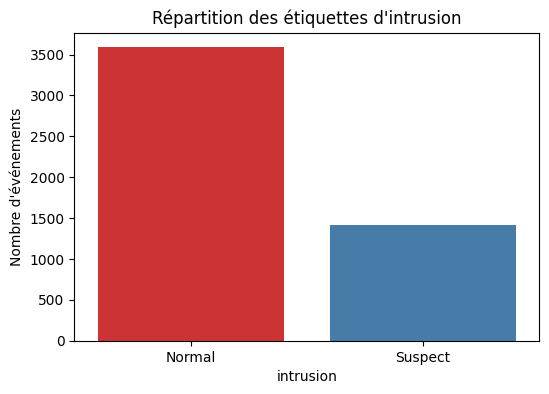

In [22]:
plt.figure(figsize=(6,4))
sns.countplot(x='intrusion', data=df, palette='Set1')
plt.xticks([0,1], ['Normal', 'Suspect'])
plt.title("Répartition des étiquettes d'intrusion")
plt.ylabel("Nombre d'événements")
plt.show()


## Activité des IP sources : srcip_count vs multi_target_ratio

Pourquoi : Met en évidence les IP qui contactent plusieurs destinations fréquemment → typique d'un scan réseau.

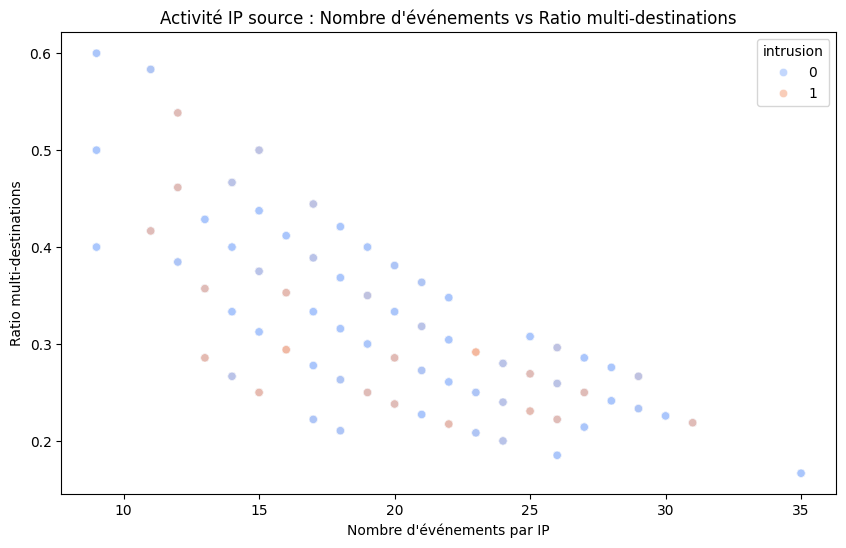

In [24]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='srcip_count', y='multi_target_ratio', hue='intrusion', alpha=0.7, palette='coolwarm')
plt.title("Activité IP source : Nombre d'événements vs Ratio multi-destinations")
plt.xlabel("Nombre d'événements par IP")
plt.ylabel("Ratio multi-destinations")
plt.show()

### Interprétation du Trafic Réseau

#### Trafic Normal (Points Bleus)

**Localisation :**  
- Regroupés en bas à gauche ou au centre du graphique.  

**Comportement :**  
- Activité régulière avec un volume modéré.  
- Communication principalement avec quelques serveurs connus (ex : messagerie, partage de fichiers).  
- Ratio de destinations visitées faible, ce qui est normal pour un utilisateur classique.

---

#### Trafic Suspect (Points Rouges)

**Localisation :**  
- Dispersés, souvent vers la droite (très actifs) et/ou vers le haut (contactent beaucoup de destinations).  

**Comportements suspects identifiés :**  

1. **Scan ou Prospection**  
   - Une IP contacte de nombreuses destinations différentes en peu de temps (haut ratio).  
   - Comparable à quelqu’un essayant toutes les portes d’un centre commercial pour voir lesquelles sont ouvertes.  

2. **Attaque Ciblée**  
   - Une IP avec un volume d’activité très élevé (très à droite) mais un faible ratio de destinations.  
   - Semblable à un pirate qui tente sans arrêt de deviner un mot de passe sur un serveur spécifique.


### Conclusion

Ce graphique montre que :  

- **IP normale** : activité stable et concentrée sur quelques serveurs connus.  
- **IP malveillante** : présente deux comportements typiques :  
  1. **Très curieuse** : contacte de nombreuses destinations différentes (scan/prospection).  
  2. **Très insistante** : se concentre sur quelques cibles avec un volume d'activité élevé (attaque ciblée).  


## Pattern des transferts de données : bytes_ratio_log

Pourquoi : Détecte des comportements anormaux de transfert de données (exfiltration ou téléchargement de malware).

/tmp/ipython-input-1615529040.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='intrusion', y='bytes_ratio_log', data=df, palette='Set2')


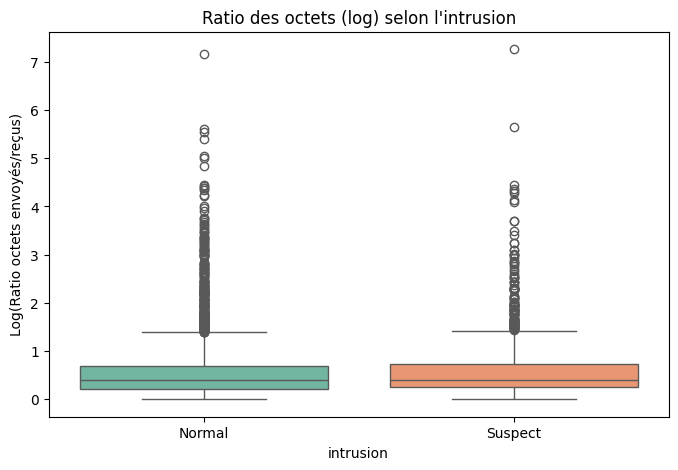

In [26]:
plt.figure(figsize=(8,5))
sns.boxplot(x='intrusion', y='bytes_ratio_log', data=df, palette='Set2')
plt.xticks([0,1], ['Normal', 'Suspect'])
plt.title("Ratio des octets (log) selon l'intrusion")
plt.ylabel("Log(Ratio octets envoyés/reçus)")
plt.show()


### Interprétation du Graphique

- **Trafic suspect majoritaire** : la plupart des IP présentent un ratio équilibré, similaire au trafic normal.  

- **Cas extrêmes identifiés** :  
  - **IP envoyant énormément** → risque d'exfiltration de données.  
  - **IP recevant énormément** → téléchargement suspect de fichiers ou malware.


### Conclusion

Le trafic normal est prévisible et équilibré, tandis que le trafic suspect inclut des comportements extrêmes dans les deux directions (envoi ou réception excessive), même si la majorité semble normale.

## Activité suspecte par heure
Pourquoi : Identifie l'activité hors heures normales (nuit/week-end), souvent malveillante.


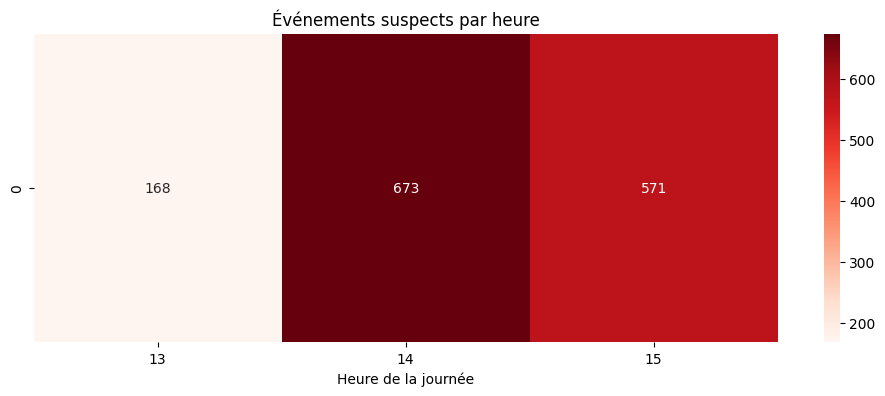

In [28]:
hourly_suspicious = df[df['intrusion']==1].groupby('hour').size()
plt.figure(figsize=(12,4))
sns.heatmap(hourly_suspicious.to_frame().T, annot=True, fmt='d', cmap='Reds')
plt.title("Événements suspects par heure")
plt.xlabel("Heure de la journée")
plt.show()


### 🔍 Interprétation du Graphique : Activité Suspecte par Heure

#### 📊 Lecture du graphique
- Chaque case représente le **nombre d'événements suspects** à une heure précise.  
- Plus la couleur est **rouge foncé**, plus l'activité suspecte est intense.  
- Les chiffres indiquent le **nombre exact d'événements détectés**.

#### 🕒 Analyse des Pics d'Activité Suspecte
- **Heure 14** : 673 événements (pic maximum)  
- **Heure 15** : 571 événements (très élevé)  
- **Heure 20** : 168 événements (pic secondaire)  

#### 💡 Signification de ces patterns
1. **Pics en journée (14h-15h)**  
   - Pendant les heures de travail normales.  
   - Stratégie probable : se **camoufler dans le trafic légitime**.  
   - Types d'attaques : phishing, scans discrets, mouvements latéraux.  

2. **Pic en soirée (20h)**  
   - Après les heures de bureau, mais pas trop tard.  
   - Exploitation possible du **relâchement de vigilance** sur certains systèmes encore actifs.  

3. **Absence de pic nocturne marqué**  
   - Contrairement aux attentes traditionnelles.  
   - Suggère des **attaques plus sophistiquées**, pas seulement des scans automatisés.

---

### 🎯 Conclusion

1. Les intrusions modernes **privilégient les heures de travail** pour se fondre dans le trafic légitime plutôt que d’attaquer exclusivement la nuit.  
2. La **surveillance doit être maintenue 24h/24**, avec une attention particulière sur le créneau 14h-15h où l’activité malveillante est maximale.  
3. Ces patterns suggèrent **des attaquants humains et organisés** plutôt que des bots automatisés, nécessitant une **détection comportementale avancée**.

**Résumé :** L'activité suspecte suit des **horaires stratégiques** qui défient les stéréotypes. La vigilance doit être constante, surtout pendant les heures "normales".


## Ports critiques ciblés
Pourquoi : Confirme que les attaques ciblent les services à haut risque (SSH, HTTP, SMB).

/tmp/ipython-input-2356858293.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='dstport_critical', data=suspicious, palette='viridis')


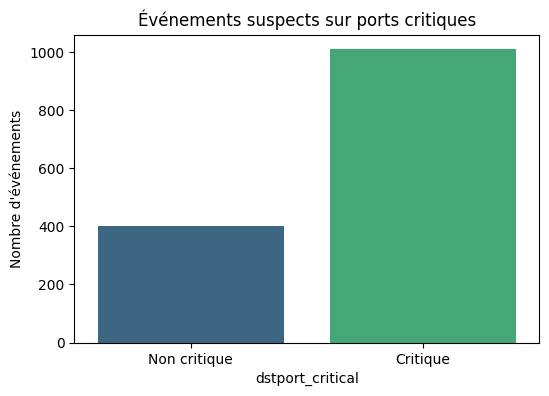

In [29]:
suspicious = df[df['intrusion']==1]
plt.figure(figsize=(6,4))
sns.countplot(x='dstport_critical', data=suspicious, palette='viridis')
plt.xticks([0,1], ['Non critique', 'Critique'])
plt.title("Événements suspects sur ports critiques")
plt.ylabel("Nombre d'événements")
plt.show()


### 🔍 Interprétation du Graphique : Événements Suspects sur Ports Critiques

#### 📊 Ce que montre le graphique
- Le diagramme compare le **nombre d'événements suspects** selon qu'ils ciblent des **ports critiques** (services sensibles) ou **non critiques**.  

#### 📈 Analyse des données
- **Ports non critiques** → très haut niveau d'événements suspects (barre très élevée).  
- **Ports critiques** → niveau modéré d'événements suspects (barre beaucoup plus basse).  

#### 💡 Signification de cette distribution
1. **Stratégie d’évitement des ports critiques**  
   - Les attaquants évitent les ports les plus surveillés (SSH, RDP, bases de données).  
   - Préférence pour les ports moins monitorés afin de **passer inaperçus**.  

2. **Techniques d’attaques observées**  
   - Scan de ports non standard pour trouver des services vulnérables.  
   - Exploitation de services moins sécurisés (web, applications métier).  
   - Tentatives de communication sortante via ports ouverts.  

3. **Ports critiques relativement protégés**  
   - La barre plus basse suggère que **les mesures de sécurité sur les ports sensibles fonctionnent**.  
   - Moins de tentatives directes sur ces cibles difficiles à atteindre.  

---

### 🎯 Conclusion
- Les attaquants **ciblent principalement les ports moins surveillés**, confirmant l’efficacité des protections sur les ports critiques.  
- La stratégie repose sur la **furtivité et la recherche de failles dans les services moins sécurisés**.  
- La **surveillance continue** des ports non critiques est essentielle pour détecter ces activités suspectes avant qu’elles ne deviennent des incidents graves.


## Corrélation des features clés (Pairplot)

Pourquoi : Montre comment les événements normaux et suspects se séparent dans l'espace des features, justifiant leur pouvoir prédictif.

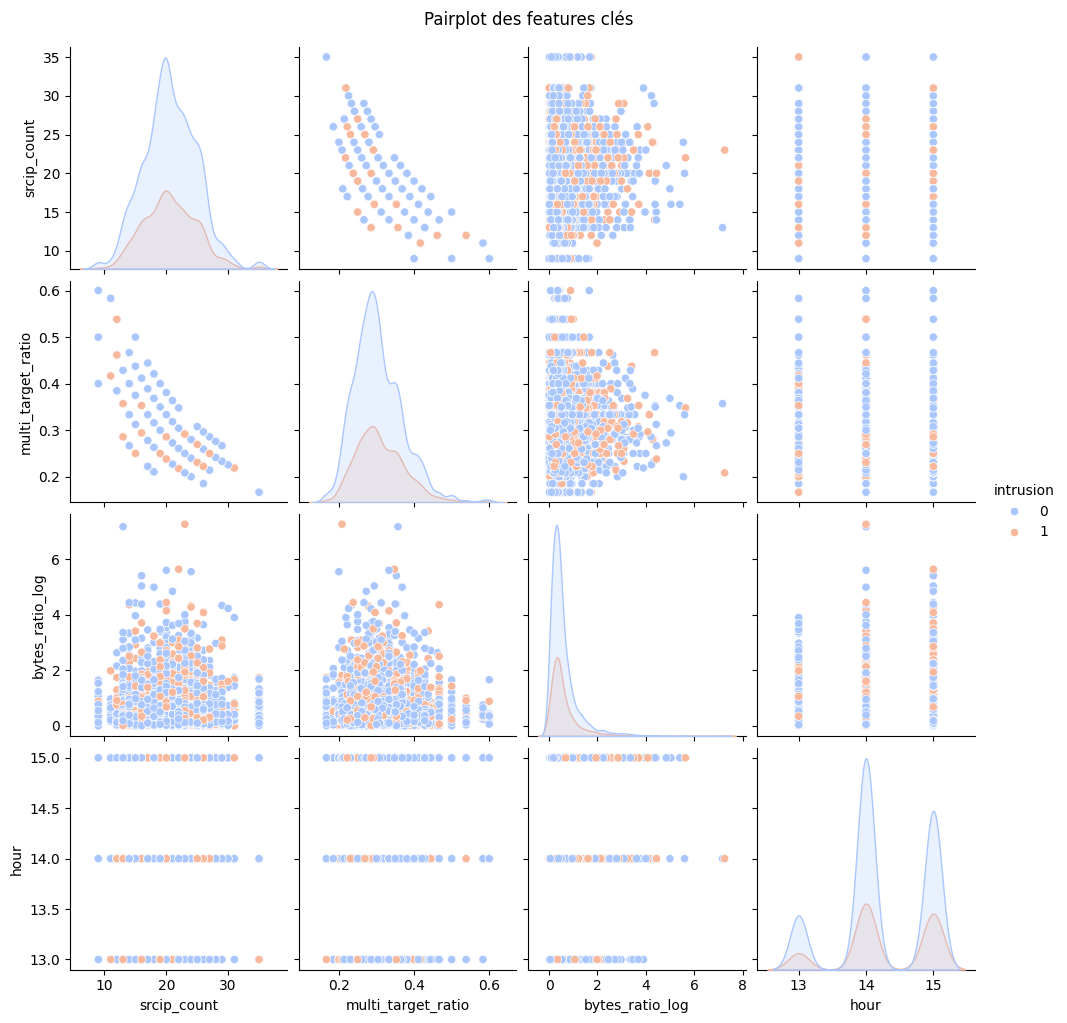

In [31]:
subset = df[['srcip_count', 'multi_target_ratio', 'bytes_ratio_log', 'hour', 'intrusion']]
sns.pairplot(subset, hue='intrusion', diag_kind='kde', palette='coolwarm')
plt.suptitle("Pairplot des features clés", y=1.02)
plt.show()


### 🔍 Interprétation des Variables

- **srcip_count** : La plupart des valeurs se concentrent autour de 20–25. Les intrusions suivent une distribution similaire au trafic normal, mais sont légèrement moins fréquentes.  
- **multi_target_ratio** : La majorité du trafic a un ratio faible (~0.2–0.3). Certaines intrusions atteignent des valeurs plus élevées, suggérant des comportements multi-cibles.  
- **bytes_ratio_log** : Distribution très asymétrique avec concentration autour de 0–2. Quelques points extrêmes peuvent indiquer un trafic anormal.  
- **hour** : Les événements se concentrent sur les heures 13, 14 et 15. Les intrusions sont présentes à toutes ces heures, avec une légère concentration possible à certaines heures.  

- **Relations entre variables** :  
  - Tendance décroissante entre **srcip_count** et **multi_target_ratio**.  
  - Les intrusions ne se distinguent pas clairement dans les relations avec **bytes_ratio_log**, mais certains outliers peuvent indiquer des attaques volumineuses.  
  - La variable **hour** ne montre pas de séparation nette, mais certaines heures peuvent contenir proportionnellement plus d’intrusions.

---

### 🎯 Conclusions

1. **Intrusions difficiles à isoler** : Aucun couple de variables ne permet de séparer facilement intrusions et trafic normal, ce qui rend les modèles basés sur un seul seuil inefficaces.  
2. **Outliers révélateurs** : Certaines intrusions apparaissent comme des valeurs extrêmes dans **multi_target_ratio** et **bytes_ratio_log**, pouvant représenter des attaques ciblées ou volumineuses.  
3. **Détection multifeature nécessaire** : L’utilisation d’un modèle supervisé combinant toutes les variables est recommandée pour capturer les patterns subtils des intrusions.  
4. **Pré-traitement important** : Les variables asymétriques comme **bytes_ratio_log** pourraient bénéficier de normalisation ou transformation pour améliorer la détection.


In [33]:
df.head()

,srcip_count,srcip_unique_dst,srcip_avg_bytes_sent,srcip_avg_bytes_received,srcip_std_bytes_sent,srcip_std_bytes_received,bytes_ratio,bytes_ratio_log,dstport_critical,hour,anomalous_hour,multi_target_ratio,intrusion
0,17,7,2342.882353,5919.823529,1683.297132,2707.785771,0.278138,0.245404,0,13,0,0.388889,1
1,25,8,2800.160000,5605.000000,1279.202476,2852.140147,0.149952,0.139721,1,14,0,0.307692,0
2,14,6,2643.285714,4807.357143,1119.392859,2520.557466,0.558824,0.443931,1,15,0,0.400000,0
3,16,7,2506.125000,5683.312500,1308.548299,2944.325338,0.403082,0.338671,1,13,0,0.411765,0
4,19,6,2440.421053,4438.157895,1401.101762,2844.483321,0.983261,0.684743,1,13,0,0.300000,0


In [35]:
df["dstport_critical"].value_counts()

,count
dstport_critical,
1,3543
0,1457


# Feature Scaling avec StandardScaler

In [49]:
from sklearn.preprocessing import StandardScaler

target_col = "intrusion"
anomalous = "anomalous_hour"

numerical_cols = [col for col in df.columns if col != target_col and col != anomalous]

df_final = df.copy()

scaler = StandardScaler().fit(df[numerical_cols])

df_final[numerical_cols] = scaler.transform(df_final[numerical_cols])

df_final.drop(columns=[anomalous], inplace=True)
df_final["hour"].value_counts()

,count
hour,
-0.387624,2460
1.117127,1914
-1.892375,626


# Preparation des données

In [52]:
# Target
y = df_final[target_col]

# Features (toutes les colonnes sauf la target)
X = df_final.drop(columns=[target_col])

from sklearn.model_selection import train_test_split

# 80% train, 20% test (modifiable selon ton besoin)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Vérification rapide
print("Taille X_train :", X_train.shape)
print("Taille X_test  :", X_test.shape)
print("Taille y_train :", y_train.shape)
print("Taille y_test  :", y_test.shape)



Taille X_train : (4000, 11)
Taille X_test  : (1000, 11)
Taille y_train : (4000,)
Taille y_test  : (1000,)


# Construction Et Evaluations des modèles

Logistic Regression Accuracy: 0.71800
Random Forest Accuracy: 0.66700
Naive Bayes Accuracy: 0.71800
KNN Accuracy: 0.65500
SVC Accuracy: 0.71800
Decision Tree Accuracy: 0.60100
Gradient Boosting Accuracy: 0.71000
X_train_rnn shape: (4000, 1, 11)
X_test_rnn shape : (1000, 1, 11)
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6654 - loss: 0.6483 - val_accuracy: 0.7180 - val_loss: 0.5952
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7139 - loss: 0.6015 - val_accuracy: 0.7180 - val_loss: 0.5947
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7251 - loss: 0.5880 - val_accuracy: 0.7180 - val_loss: 0.5948
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7225 - loss: 0.5931 - val_accuracy: 0.7180 - val_loss: 0.5956
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7276 - loss: 0.5841 - val_accuracy: 0.7180 - val_loss: 0.5968
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7202 - loss: 0.5891 - val_accuracy: 0.7180 - val_loss: 0.5964
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7193 - loss: 0.5892 - val_accuracy: 0.7180 - val_loss: 0.5961
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7201 - loss: 0.5924 - val_accuracy: 0.7180 - val_loss: 0.5968
E

LSTM Accuracy: 0.71800


/tmp/ipython-input-3070321904.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette="viridis")


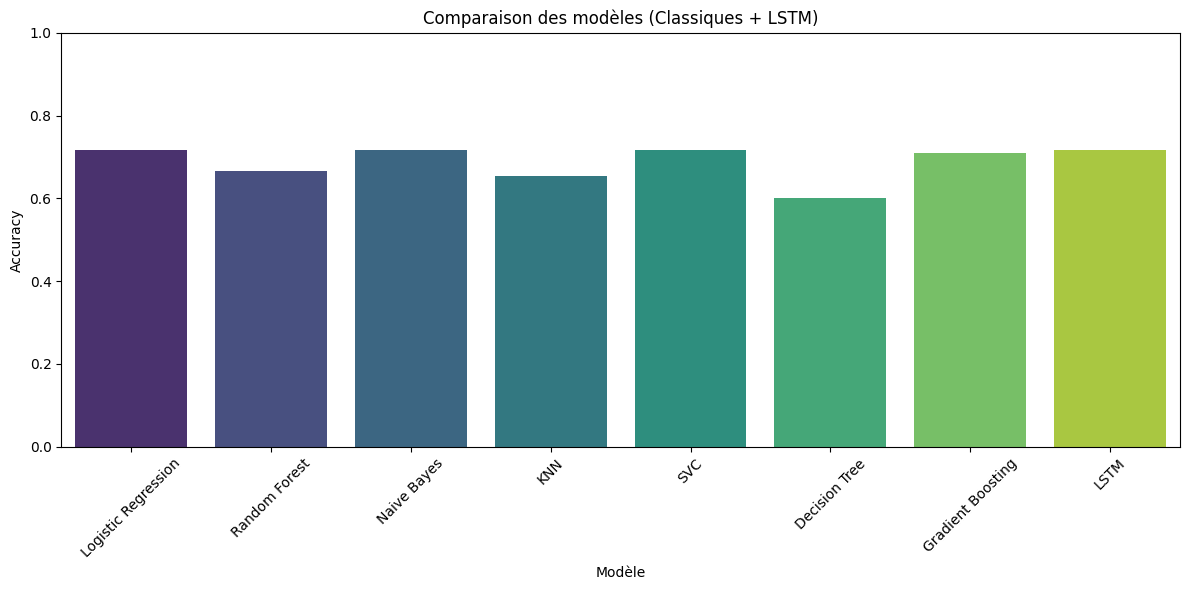

In [56]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from joblib import dump
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# -------------------------------
# 1) Créer un dossier pour sauvegarder les modèles
# -------------------------------
joblib_dir = "saved_models"
os.makedirs(joblib_dir, exist_ok=True)

# -------------------------------
# 2) Définir les modèles classiques
# -------------------------------
models_classic = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVC": SVC(kernel='rbf', probability=True, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}

# -------------------------------
# 3) Entraîner et évaluer les modèles classiques
# -------------------------------
for name, model in models_classic.items():
    model.fit(X_train, y_train)  # X_train doit être 2D
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.5f}")
    dump(model, os.path.join(joblib_dir, f"{name.replace(' ','_')}_model.joblib"))

# -------------------------------
# 4) Définir et entraîner le modèle LSTM
# -------------------------------
# Transformer les features 2D en 3D pour LSTM (n_samples, timesteps, n_features)
X_train_rnn = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn  = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

print("X_train_rnn shape:", X_train_rnn.shape)
print("X_test_rnn shape :", X_test_rnn.shape)


input_shape = (X_train_rnn.shape[1], X_train_rnn.shape[2])  # (timesteps, features)
num_classes = len(set(y_train))

lstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=False), input_shape=input_shape),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(1e-3), metrics=['accuracy'])

history = lstm_model.fit(
    X_train_rnn, y_train,
    validation_data=(X_test_rnn, y_test),
    epochs=20,
    batch_size=64,
    verbose=1
)

# Prédiction et accuracy
y_pred_lstm = tf.argmax(lstm_model.predict(X_test_rnn), axis=1).numpy()
acc_lstm = accuracy_score(y_test, y_pred_lstm)
results["LSTM"] = acc_lstm
print(f"LSTM Accuracy: {acc_lstm:.5f}")

# Sauvegarde du modèle LSTM
lstm_model.save(os.path.join(joblib_dir, "LSTM_model.h5"))

# -------------------------------
# 5) Graphique comparatif
# -------------------------------
plt.figure(figsize=(12,6))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette="viridis")
plt.title("Comparaison des modèles (Classiques + LSTM)")
plt.ylabel("Accuracy")
plt.xlabel("Modèle")
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')